In [1]:
1

1

In [2]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt

In [3]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))
            if layer_size ==5:
                model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv5' ))
                model.add(BatchNormalization())
                model.add(Activation("relu"))
                model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [4]:
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-train.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-val.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
#Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

pkl_path_test = "/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-08_Q-01_order2_fold-test.pkl"
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)

In [5]:
#fix everybody's physical parameters first (p and D should be log)
#print(np.log10(y_train[0,3]),y_train[0,3])
import math
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
    y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

In [6]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
for idx in range(2,4):
    params[:,idx] = [math.log10(i) for i in params[:,idx]]

scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [7]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]

In [8]:
Sy_train_log2 = np.log1p(((Sy_train>0)*Sy_train)/1e-11)
Sy_val_log2 = np.log1p(((Sy_val>0)*Sy_val)/1e-11)
Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/1e-11)

In [29]:
print(np.max(np.max(np.max(Sy_train_log2))),np.min(np.min(np.min(Sy_train_log2))))

24.584995 -0.0


In [9]:
Sy_val_log2.shape

(7776, 128, 43)

(array([ 16.,  45.,  90.,  91.,  50.,  10.,   6.,  13.,  22.,  37.,  73.,
        102., 159., 227., 212., 199., 188., 130., 137., 131., 208., 214.,
        235., 184., 192., 245., 351., 460., 530., 492., 451., 313., 243.,
        192., 159., 135., 201., 212., 222., 226., 185., 125., 130., 135.,
        192., 161., 134.,  73.,  95.,  76., 132., 167., 142.,  98.,  47.,
         47.,  87., 159., 221., 228., 126.,  97., 130., 121.,  81.,  94.,
         81.,  53.,  22.,  13.,  11.,  32.,  36.,  67., 121., 153., 120.,
         84.,  88.,  66.,  27.,   1.,   1.,  35.,  56.,  80.,  95.,  32.,
          0.,   0.,   0.,  37.,  82., 109., 161., 224.,  95.,  75.,  83.,
         31.]),
 array([11.785914 , 11.9023075, 12.018701 , 12.135095 , 12.251488 ,
        12.367881 , 12.484274 , 12.600667 , 12.717061 , 12.833454 ,
        12.949847 , 13.06624  , 13.182633 , 13.2990265, 13.415421 ,
        13.531814 , 13.648207 , 13.7646   , 13.880993 , 13.997387 ,
        14.11378  , 14.230173 , 14.346566 , 14

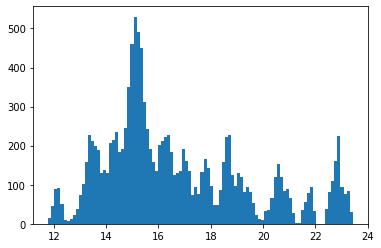

In [10]:
plt.hist(np.ndarray.flatten(Sy_val_log2[1:300,1,:]),100)

In [53]:
trial_dir = "../output/nonlinear_test2/"
best_validation_loss = np.inf
n = Sy_train.shape[0]
steps_per_epoch = 100
bs = 32
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
model=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
for epoch in range(80):
    np.random.shuffle(idx)
    Sy_temp = Sy_train_log2[idx[:m],:,:]
    y_temp = y_train_normalized[idx[:m],:]
    
    hist = model.fit(Sy_temp,
                y_temp,
                epochs=1,
                verbose=2,
                batch_size=bs,
                validation_data = (Sy_val_log2,y_val_normalized),
                use_multiprocessing=False)
    validation_loss = hist.history['val_loss'][0]
    val_loss.append(validation_loss)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        epoch_str = "epoch-" + str(epoch).zfill(3)
        epoch_network_path = os.path.join(
           trial_dir, "_".join(["j8o2", epoch_str]) + "-log2.h5")
        model.save(epoch_network_path)
        

Train on 3200 samples, validate on 7776 samples
3200/3200 - 3s - loss: 0.3232 - mean_squared_error: 0.3232 - val_loss: 0.0982 - val_mean_squared_error: 0.0982
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0965 - val_mean_squared_error: 0.0965
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0561 - mean_squared_error: 0.0561 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0538 - mean_squared_error: 0.0538 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Train on 3200 samples, validate on 7776 sample

Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.1921 - val_mean_squared_error: 0.1921
Train on 3200 samples, validate on 7776 samples
3200/3200 - 2s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0394 - val_mean_squared_error: 0.0394
Train on 3200 samples, validate on 7776 sample

In [32]:
i=1200
original = y_test_normalized[i,:]
Sx = Sy_test_log2[i,:,:]
recovered = model.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.13351093 0.94689495 0.7847013  0.79656343 0.28849735] [[-0.11454172  0.7541124   0.5277499   0.5947709   0.33286726]]


In [43]:
print(original,recovered)

[0.07411863 0.84310174 0.55710213 0.29067493 0.91585758] [[0.50843346 0.4044962  0.436315   0.616282   0.67034876]]


In [54]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model2.load_weights("../output/nonlinear_test2/j8o2_epoch-077-log2.h5")

## best model so far is batch 32 step size 100 for 77 epochs
how is it doing on each physical parameter?

according to ground truth labels, all parameters are uniformly distributed

(array([787., 769., 790., 802., 739., 767., 776., 796., 781., 769.]),
 array([0.2000408 , 0.26000927, 0.31997775, 0.37994622, 0.4399147 ,
        0.49988317, 0.55985165, 0.61982012, 0.67978859, 0.73975707,
        0.79972554]),
 <a list of 10 Patch objects>)

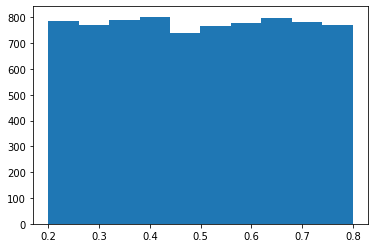

In [74]:
b = []
a = [1,2,3]
b.append(a)
b.append(a)
np.stack(b)
print(b)

[[1, 2, 3], [1, 2, 3]]


In [84]:
diff = []
for i in range(2000):
    original = y_train_normalized[i,:]
    Sx = Sy_train_log2[i,:,:]
    recovered = model2.predict(Sx.reshape((1,128,43)))
    diff.append(recovered-original)
diff_stacked = np.stack(np.abs(diff))

how does each physcial parameter error looks like"

In [85]:
diff_stacked.shape

(2000, 1, 5)

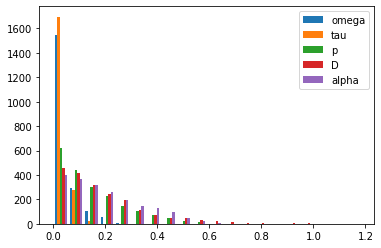

In [88]:
plt.hist(diff_stacked[:,0,:],20)
plt.legend(['omega','tau','p','D','alpha'])

(array([322., 221., 156., 119.,  73.,  49.,  28.,  23.,   6.,   3.]),
 array([6.52339268e-05, 6.26760694e-02, 1.25286905e-01, 1.87897740e-01,
        2.50508576e-01, 3.13119411e-01, 3.75730247e-01, 4.38341082e-01,
        5.00951917e-01, 5.63562753e-01, 6.26173588e-01]),
 <a list of 10 Patch objects>)

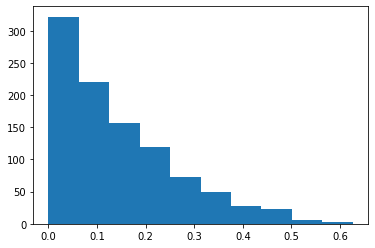

In [80]:
plt.hist(diff_stacked[:,0,2])

In [65]:
i=1199
original = y_train_normalized[i,:]
Sx = Sy_train_log2[i,:,:]
recovered = model2.predict(Sx.reshape((1,128,43)))
print(original,recovered)

[0.91303774 0.93262884 0.77100404 0.29490739 0.30083545] [[0.86738974 0.94374514 0.77592707 0.34002268 0.35929015]]


In [57]:
model2.evaluate(Sy_test_log2,y_test_normalized)

10000/10000 [==============================] - 1s 123us/sample - loss: 0.0314 - mean_squared_error: 0.0314


[0.031431474763154985, 0.031431478]

In [58]:
model2.evaluate(Sy_train_log2,y_train_normalized)

82224/82224 [==============================] - 9s 110us/sample - loss: 0.0315 - mean_squared_error: 0.0315


[0.031536917375245895, 0.031536873]

In [59]:
model2.evaluate(Sy_val_log2,y_val_normalized)

7776/7776 [==============================] - 1s 111us/sample - loss: 0.0121 - mean_squared_error: 0.0121


[0.01209811591294138, 0.012098117]

In [25]:
model2=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
recovereds=[]
for i in range(1,30):
    if i<10:
        num="00"+str(i)
    else:
        num="0"+str(i)
    model2.load_weights("../output/j8o2_epoch-"+num+"-log2.h5")
    idx=900
    original = y_test_normalized[idx,:]
    Sx = Sy_test_log2[idx,:,:]
    recovered = model2.predict(Sx.reshape((1,128,43)))
    recovereds.append(recovered)
print(original,recovereds)

[0.18508676 0.15778566 0.83393416 0.6973833  0.38978658] [array([[ 0.12924188, -0.01282368, -0.01827345,  0.00709136,  0.1449491 ]],
      dtype=float32), array([[ 0.16703765,  0.03420937, -0.01650573,  0.03284939,  0.15856506]],
      dtype=float32), array([[0.17951101, 0.15352775, 0.00698536, 0.03333293, 0.1192532 ]],
      dtype=float32), array([[0.19032335, 0.23737423, 0.06644126, 0.04796477, 0.10021573]],
      dtype=float32), array([[0.22111303, 0.30277777, 0.05979192, 0.08614463, 0.09556869]],
      dtype=float32), array([[0.23447618, 0.36542296, 0.0795739 , 0.09382316, 0.08278787]],
      dtype=float32), array([[0.25511226, 0.4268223 , 0.1088834 , 0.15652221, 0.12793535]],
      dtype=float32), array([[0.28713715, 0.4589598 , 0.11357147, 0.2260835 , 0.17895496]],
      dtype=float32), array([[0.33276492, 0.48091692, 0.13084042, 0.31558216, 0.27293137]],
      dtype=float32), array([[0.34118453, 0.5241515 , 0.18215108, 0.34584472, 0.27927658]],
      dtype=float32), array([[0.36

In [27]:
model3=create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)
model3.load_weights("../output/j8o2_epoch-001-log2.h5")
recovereds=[]
for i in range(1,30):
    idx=i
    original = y_test_normalized[idx,:]
    Sx = Sy_test_log2[idx,:,:]
    recovered = model3.predict(Sx.reshape((1,128,43)))
    recovereds.append(recovered)
print(original,recovereds)

[0.73148035 0.71185277 0.5859216  0.68880883 0.92923907] [array([[ 0.16870654, -0.11933641,  0.04332103,  0.09887189,  0.2645198 ]],
      dtype=float32), array([[0.11705386, 0.04620991, 0.0359511 , 0.07052191, 0.08028968]],
      dtype=float32), array([[ 0.11820751,  0.11773452, -0.02517378,  0.02660449,  0.0588664 ]],
      dtype=float32), array([[ 0.18399005, -0.12796356,  0.03819741,  0.07275039,  0.22930585]],
      dtype=float32), array([[0.11751596, 0.03906371, 0.03433005, 0.07067346, 0.08705397]],
      dtype=float32), array([[ 0.1794035 , -0.17564707,  0.09821105,  0.12537543,  0.322071  ]],
      dtype=float32), array([[ 1.4711931e-01, -2.6992422e-02,  9.5795840e-06,  5.8835857e-02,
         1.8940987e-01]], dtype=float32), array([[ 0.11390976,  0.07119198, -0.00798965,  0.03873477,  0.10203451]],
      dtype=float32), array([[ 0.11177225,  0.13923319, -0.01978726,  0.05249289,  0.05641059]],
      dtype=float32), array([[ 0.14948045, -0.00928066,  0.02754237,  0.05446425,  0